In [2]:
import pandas as pd

train = pd.read_csv('train.csv')
holdout = pd.read_csv('test.csv')

In [1]:
# Preprocessing
def process_missing(df):
    """Handle various missing values from the data set

    Usage
    ------

    holdout = process_missing(holdout)
    """
    df["Fare"] = df["Fare"].fillna(train["Fare"].mean())
    df["Embarked"] = df["Embarked"].fillna("S")
    return df

def process_age(df):
    """Process the Age column into pre-defined 'bins' 

    Usage
    ------

    train = process_age(train)
    """
    df["Age"] = df["Age"].fillna(-0.5)
    cut_points = [-1,0,5,12,18,35,60,100]
    label_names = ["Missing","Infant","Child","Teenager","Young Adult","Adult","Senior"]
    df["Age_categories"] = pd.cut(df["Age"],cut_points,labels=label_names)
    return df

def process_fare(df):
    """Process the Fare column into pre-defined 'bins' 

    Usage
    ------

    train = process_fare(train)
    """
    cut_points = [-1,12,50,100,1000]
    label_names = ["0-12","12-50","50-100","100+"]
    df["Fare_categories"] = pd.cut(df["Fare"],cut_points,labels=label_names)
    return df

def process_cabin(df):
    """Process the Cabin column into pre-defined 'bins' 

    Usage
    ------

    train process_cabin(train)
    """
    df["Cabin_type"] = df["Cabin"].str[0]
    df["Cabin_type"] = df["Cabin_type"].fillna("Unknown")
    df = df.drop('Cabin',axis=1)
    return df

def process_titles(df):
    """Extract and categorize the title from the name column 

    Usage
    ------

    train = process_titles(train)
    """
    titles = {
        "Mr" :         "Mr",
        "Mme":         "Mrs",
        "Ms":          "Mrs",
        "Mrs" :        "Mrs",
        "Master" :     "Master",
        "Mlle":        "Miss",
        "Miss" :       "Miss",
        "Capt":        "Officer",
        "Col":         "Officer",
        "Major":       "Officer",
        "Dr":          "Officer",
        "Rev":         "Officer",
        "Jonkheer":    "Royalty",
        "Don":         "Royalty",
        "Sir" :        "Royalty",
        "Countess":    "Royalty",
        "Dona":        "Royalty",
        "Lady" :       "Royalty"
    }
    extracted_titles = df["Name"].str.extract(' ([A-Za-z]+)\.',expand=False)
    df["Title"] = extracted_titles.map(titles)
    return df

def create_dummies(df,column_name):
    """Create Dummy Columns (One Hot Encoding) from a single Column

    Usage
    ------

    train = create_dummies(train,"Age")
    """
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

def preprocess_df(df):
    df = process_missing(df)
    df = process_age(df)
    df = process_fare(df)
    df = process_titles(df)
    df = process_cabin(df)
    
    for column in ['Age_categories', 'Fare_categories', 'Title', 'Cabin_type', 'Sex']:
        df = create_dummies(df, column)
        
    return df

# Create new features
def process_family(df):
    """Create Family_size column calculated from Parch and SibSp

    Usage
    ------

    train = process_family(train)
    """
    df['familysize'] = df.apply(lambda row: row['Parch'] + row['SibSp'], axis=1)
    return df

def process_isalone(df):
    df['isalone'] = (df['familysize'] == 0).astype(int)
    return df

In [3]:
train = preprocess_df(train)
holdout = preprocess_df(holdout)

int64


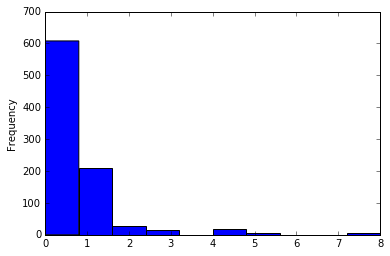

SibSp
0    0.345395
1    0.535885
2    0.464286
3    0.250000
4    0.166667
5    0.000000
8    0.000000
Name: Survived, dtype: float64
int64


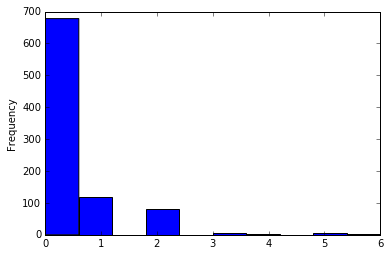

Parch
0    0.343658
1    0.550847
2    0.500000
3    0.600000
4    0.000000
5    0.200000
6    0.000000
Name: Survived, dtype: float64


In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

for column in ['SibSp', 'Parch']:
    # show type
    print(train[column].dtype)
    # see distribution
    train[column].plot.hist()
    plt.show()
    # pivot table survival
    print(pd.pivot_table(train, columns=column, values='Survived'))


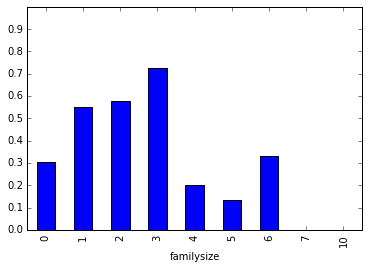

In [6]:
import numpy as np

train = process_family(train)
train = process_isalone(train)
holdout = process_family(holdout)
holdout = process_isalone(holdout)

pd.pivot_table(train, index='familysize', values='Survived').plot.bar(ylim=(0, 1), yticks=np.arange(0, 1, .1))

In [7]:
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier

def select_features(df):
    # df is copied
    # remove non-numeric
    df = df.select_dtypes([np.number])
    # remove NaNs
    df = df.dropna(axis=1)
    # create all_X (without PassengerId and Survived) and all_y
    columns_to_drop = ['PassengerId']
    df = df.drop(columns_to_drop, axis=1)
    target_column = 'Survived'
    all_X = df.drop(target_column, axis=1)
    all_y = df[target_column]
    # use RFECV with RandomForest - all_X, all_y, random_state=1, cv=10
    rf = RandomForestClassifier(random_state=1)
    selector = RFECV(rf, cv=10)
    selector.fit(all_X, all_y)

    best_columns = all_X.columns[selector.support_]
    print(best_columns)
    return best_columns

best_features = select_features(train)

Best Columns 
------------
Index(['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Age_categories_Missing',
       'Age_categories_Infant', 'Age_categories_Child',
       'Age_categories_Teenager', 'Age_categories_Young Adult',
       'Age_categories_Adult', 'Age_categories_Senior', 'Fare_categories_0-12',
       'Fare_categories_12-50', 'Fare_categories_50-100',
       'Fare_categories_100+', 'Title_Master', 'Title_Miss', 'Title_Mr',
       'Title_Mrs', 'Title_Officer', 'Title_Royalty', 'Cabin_type_A',
       'Cabin_type_B', 'Cabin_type_C', 'Cabin_type_D', 'Cabin_type_E',
       'Cabin_type_F', 'Cabin_type_G', 'Cabin_type_Unknown', 'Sex_female',
       'Sex_male', 'familysize', 'isalone'],
      dtype='object')



In [8]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

def select_model(df, features):
    target_column = 'Survived'
    all_X = df[features]
    all_y = df[target_column]
    estimators_grid = [
        {
            'name': 'LogisticRegression',
            'estimator': LogisticRegression(),
            'hyperparameters': {
                'solver': ['newton-cg', 'lbfgs', 'liblinear'],
            }
        },
        {
            'name': 'KNeighborsClassifier',
            'estimator': KNeighborsClassifier(),
            'hyperparameters': {
                'n_neighbors': range(1, 20, 2),
                'weights': ['distance', 'uniform'],
                'algorithm': ['ball_tree', 'kd_tree', 'brute'],
                'p': [1, 2],
            }
        },
        {
            'name': 'RandomForestClassifier',
            'estimator': RandomForestClassifier(),
            'hyperparameters': {
                'n_estimators': [4, 6, 9],
                'criterion': ['entropy', 'gini'],
                'max_depth': [2, 5, 10],
                'max_features': ['log2', 'sqrt'],
                'min_samples_leaf': [1, 5, 8],
                'min_samples_split': [2, 3, 5],
            }
        }
    ]
    for estimator in estimators_grid:
        print(estimator['name'])
        grid = GridSearchCV(estimator['estimator'], param_grid=estimator['hyperparameters'], cv=10)
        grid.fit(all_X, all_y)
        estimator['best_params'] = grid.best_params_
        estimator['score'] = grid.best_score_
        estimator['best_estimator'] = grid.best_estimator_
        print('params: {}\nscore: {}\n'.format(estimator['best_params'], estimator['score']))
    return estimators_grid

best_model = select_model(train, best_features)

LogisticRegression
params: {'solver': 'lbfgs'}
score: 0.819304152637486

KNeighborsClassifier
params: {'weights': 'uniform', 'algorithm': 'kd_tree', 'p': 1, 'n_neighbors': 3}
score: 0.7800224466891134

RandomForestClassifier
params: {'max_features': 'sqrt', 'min_samples_leaf': 5, 'criterion': 'gini', 'min_samples_split': 3, 'max_depth': 10, 'n_estimators': 9}
score: 0.8406285072951739



In [9]:
best_score = 0.0
best_estimator = None
for model in best_model:
    if model['score'] > best_score:
        best_score = model['score']
        best_estimator = model['best_estimator']
best_estimator

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=5,
            min_samples_split=3, min_weight_fraction_leaf=0.0,
            n_estimators=9, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [10]:
def save_submission_file(model, columns, filename='submission.csv'):
    holdout_prediction = model.predict(holdout[columns])
    submission = pd.DataFrame({'PassengerId': holdout['PassengerId'], 'Survived': holdout_prediction})
    submission.to_csv(filename, index=False)

save_submission_file(best_estimator, best_features)